In [ ]:
! pip install torch  torchvision


In [ ]:
! pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=2e545f8cfb90b4e6e9d64a638413879383e0d04d97ee23a5ae587f394551dbed
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import grad
from pyDOE import lhs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import torch.optim as optim
import csv
import os
import imageio

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

torch.manual_seed(1234)
np.random.seed(1234)


if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1234)

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(device)

True
1
cuda


In [ ]:
x_min = 0.0
x_max = 1.0
y_min = 0.0
y_max = 1.0
N_b = 4000
N_i = 20000
N_c = 20000
t_min = 0
t_max = 1

alpha = 0.1

ub = np.array([x_max , y_max , t_max])
lb = np.array([x_min , y_min , t_min])


T_l = 300/400
T_r = 300/400
T_b = 400/400
T_t = 273/400
T_i = 273/400

def getData():


    left_wall = [x_min, y_min, t_min] + [0.0, y_max-y_min, t_max] * lhs(3, N_b)
    right_wall = [x_max, y_min, t_min] + [0.0, y_max-y_min, t_max] * lhs(3, N_b)
    bottom_wall = [x_min, y_min, t_min] + [x_max-x_min, 0.0, t_max] * lhs(3, N_b)
    top_wall = [x_min, y_max, t_min] + [x_max-x_min, 0.0, t_max] * lhs(3, N_b)

    T_left = np.full((N_b, 1), T_l)
    T_right = np.full((N_b, 1), T_r)
    T_bottom = np.full((N_b, 1), T_b)
    T_top = np.full((N_b, 1), T_t)

    xyt_bnd = np.concatenate([top_wall, bottom_wall,right_wall,left_wall], axis=0)
    T_bnd = np.concatenate([T_top, T_bottom ,T_right, T_left], axis=0)

        # Initial
    xyt_ic = [x_min, y_min, t_min] + [x_max-x_min, y_max - y_min, 0.0] * lhs(3, N_i)
    T_ic = np.full((N_i, 1), T_i)

    # Generate collocation points
    xyt_col = lb + (ub - lb) * lhs(3, N_c)
    #xyt_col = np.concatenate((xyt_col, xyt_bnd), axis=0)
    xyt_col = np.concatenate((xyt_col, xyt_bnd, xyt_ic), axis=0)

    xyt_bnd = torch.tensor(xyt_bnd, dtype=torch.float32).to(device)
    T_bnd = torch.tensor(T_bnd, dtype=torch.float32).to(device)
    xyt_col = torch.tensor(xyt_col, dtype=torch.float32).to(device)
    xyt_ic = torch.tensor(xyt_ic, dtype=torch.float32).to(device)
    T_ic = torch.tensor(T_ic, dtype=torch.float32).to(device)

    return  xyt_bnd, T_bnd, xyt_col, xyt_ic, T_ic

xyt_bnd, T_bnd, xyt_col, xyt_ic, T_ic  = getData()

# fig, ax = plt.subplots()
# ax.set_aspect('equal')
# plt.scatter(xyt_col[:,0:1], xyt_col[:,1:2], marker='o', alpha=0.4 ,color='blue')
# plt.scatter(xyt_bnd[:,0:1], xyt_bnd[:,1:2], marker='o', alpha=0.4 ,color='red')
# plt.show()

# fig, ax = plt.subplots()
# plt.scatter(T_ic, xyt_ic[:,2:3], marker='o', alpha=0.4 ,color='blue')

In [ ]:
def plotLoss(losses_dict, path, info=["B.C.", "I.C.", "P.D.E."]):
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 6))
    axes[0].set_yscale("log")
    for i, j in zip(range(3), info):
        axes[i].plot(losses_dict[j.lower()])
        axes[i].set_title(j)
    plt.show()
    fig.savefig(path)

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)

In [ ]:
class layer(nn.Module):

    def __init__(self, n_in, n_out, activation):
        super().__init__()
        self.layer = nn.Linear(n_in, n_out)
        self.activation = activation

    def forward(self, x):
        x = self.layer(x)
        if self.activation:
            x = self.activation(x)
        return x

In [ ]:
class DNN(nn.Module):

    def __init__(self, dim_in, dim_out, n_layer, n_node, ub, lb, activation=nn.Tanh()):
        super().__init__()
        self.net = nn.ModuleList()
        self.net.append(layer(dim_in, n_node, activation))
        for _ in range(n_layer):
            self.net.append(layer(n_node, n_node, activation))
        self.net.append(layer(n_node, dim_out, activation=None))
        self.ub = torch.tensor(ub, dtype=torch.float).to(device)
        self.lb = torch.tensor(lb, dtype=torch.float).to(device)
        self.net.apply(weights_init)

    def forward(self, x):
        x = (x - self.lb) / (self.ub - self.lb)
        out = x
        for layer in self.net:
            out = layer(out)
        return out

In [ ]:
class PINN:

    def __init__(self) -> None:
        self.net = DNN(dim_in=3, dim_out=3, n_layer=4, n_node=50, ub=ub, lb=lb).to(
            device
        )

        self.lbfgs = torch.optim.LBFGS(
            self.net.parameters(),
            lr=0.1,
            max_iter=20000,
            max_eval=20000,
            tolerance_grad=1e-7,
            tolerance_change= 1 * np.finfo(float).eps,
            history_size=100,
            line_search_fn="strong_wolfe",
        )

        self.adam = torch.optim.Adam(self.net.parameters() ,lr = 1e-3)
        self.losses = {"bc": [], "ic" :[], "pde": []}
        self.iter = 0

    def predict(self, X):
        out = self.net(X)

        T = out[:, 0:1]
        q_x = out[:, 1:2]
        q_y = out[:, 2:3]

        return T, q_x, q_y


    def bc_loss(self, X):
        T = self.predict(X)[0]

        mse_bc = torch.mean(torch.square(T - T_bnd))

        return mse_bc

    def ic_loss(self, X):
        T = self.predict(X)[0]

        mse_ic = torch.mean(torch.square(T - T_ic))

        return mse_ic


    def pde_loss(self, X):
        X = X.clone()
        X.requires_grad = True

        T, q_x, q_y = self.predict(X)

        T_out = grad(T.sum(), X, create_graph=True)[0]
        q_x_out = grad(q_x.sum(), X, create_graph=True)[0]
        q_y_out = grad(q_y.sum(), X, create_graph=True)[0]

        T_x = T_out[:, 0:1]
        T_y = T_out[:, 1:2]
        T_t = T_out[:, 2:3]
        q_x_x = q_x_out[:, 0:1]
        q_y_y = q_y_out[:, 1:2]

        f0 = T_t - alpha * (q_x_x + q_y_y)
        f1 = q_x - T_x
        f2 = q_y - T_y

        mse_f0 = torch.mean(torch.square(f0))
        mse_f1 = torch.mean(torch.square(f1))
        mse_f2 = torch.mean(torch.square(f2))

        mse_pde0 = mse_f0
        mse_pde1 = mse_f1
        mse_pde2 = mse_f2

        return mse_pde0 + mse_pde1 + mse_pde2

    def closure(self):

        self.lbfgs.zero_grad()
        self.adam.zero_grad()

        mse_bc = self.bc_loss(xyt_bnd) * 100
        mse_ic = self.ic_loss(xyt_ic) * 10
        mse_pde = self.pde_loss(xyt_col)

        loss = mse_bc + mse_pde + mse_ic

        loss.backward()


        self.losses["bc"].append(mse_bc.detach().cpu().item())
        self.losses["ic"].append(mse_ic.detach().cpu().item())
        self.losses["pde"].append(mse_pde.detach().cpu().item())

        self.iter += 1

        print(
            f"\r It: {self.iter} Loss: {loss.item():.5e} BC: {mse_bc.item():.3e} IC: {mse_ic.item():.3e}  pde: {mse_pde.item():.3e}",
            end="",
        )

        if self.iter % 100 == 0:
            print("")


        return loss

In [ ]:
if __name__ == "__main__":

    pinn = PINN()
    start_time = time.time()

    for i in range(8000):
        pinn.closure()
        pinn.adam.step()
    pinn.lbfgs.step(pinn.closure)

    print("--- %s seconds ---" % (time.time() - start_time))
    print(f'-- {(time.time() - start_time)/60} mins --')
    torch.save(pinn.net.state_dict(), "/content/Param.pt")
    plotLoss(pinn.losses, "/content/LossCurve.png", ["BC","IC","PDE"])



def save_losses_to_csv(losses, filename="losses.csv"):
    # Open the CSV file for writing
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write the header
        writer.writerow(["Iteration", "BC Loss", "IC Loss", "PDE Loss"])

        # Write the losses data
        for i, loss in enumerate(losses):
            writer.writerow([i] + loss)  # Assuming each loss is a tuple or list of 3 elements (BC, IC, PDE)

# Call the function to save losses
save_losses_to_csv(pinn.losses, "losses.csv")


 It: 100 Loss: 6.26007e-01 BC: 5.035e-01 IC: 1.025e-01  pde: 2.000e-02
 It: 200 Loss: 5.66124e-01 BC: 4.438e-01 IC: 1.032e-01  pde: 1.909e-02
 It: 300 Loss: 5.17680e-01 BC: 3.912e-01 IC: 1.075e-01  pde: 1.894e-02
 It: 400 Loss: 4.67707e-01 BC: 3.470e-01 IC: 1.028e-01  pde: 1.788e-02
 It: 500 Loss: 4.07541e-01 BC: 3.053e-01 IC: 8.643e-02  pde: 1.584e-02
 It: 600 Loss: 3.48482e-01 BC: 2.598e-01 IC: 7.274e-02  pde: 1.592e-02
 It: 700 Loss: 2.87869e-01 BC: 2.025e-01 IC: 6.178e-02  pde: 2.355e-02
 It: 800 Loss: 2.46677e-01 BC: 1.591e-01 IC: 5.338e-02  pde: 3.420e-02
 It: 900 Loss: 2.26879e-01 BC: 1.420e-01 IC: 4.785e-02  pde: 3.705e-02
 It: 1000 Loss: 2.16803e-01 BC: 1.353e-01 IC: 4.415e-02  pde: 3.733e-02
 It: 1100 Loss: 2.08824e-01 BC: 1.317e-01 IC: 4.181e-02  pde: 3.531e-02
 It: 1200 Loss: 2.01548e-01 BC: 1.290e-01 IC: 4.024e-02  pde: 3.232e-02
 It: 1300 Loss: 1.95065e-01 BC: 1.269e-01 IC: 3.881e-02  pde: 2.937e-02
 It: 1400 Loss: 1.89315e-01 BC: 1.248e-01 IC: 3.756e-02  pde: 2.695e-02
 

/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


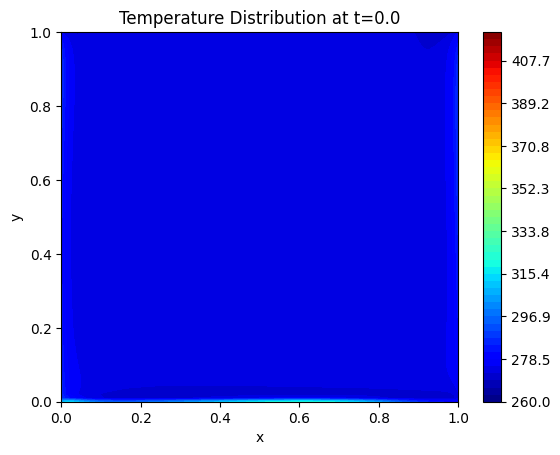

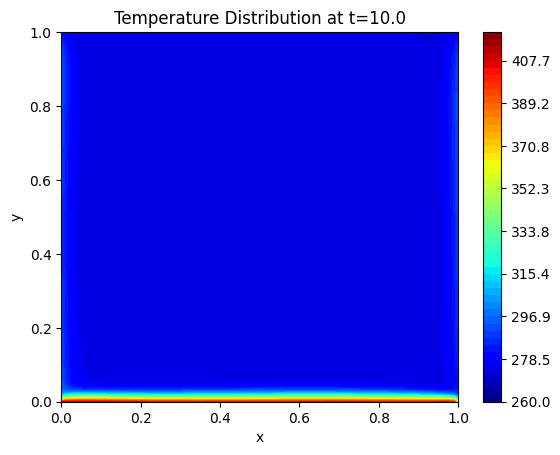

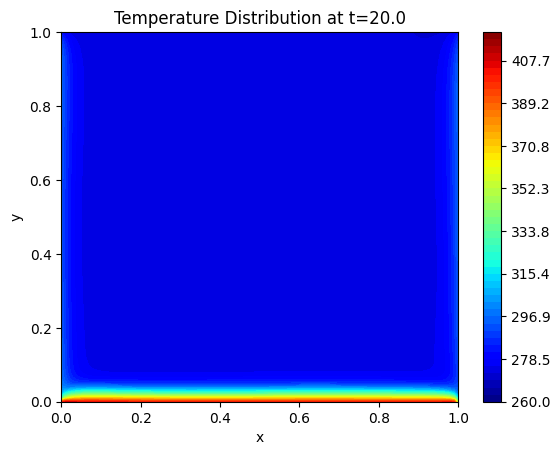

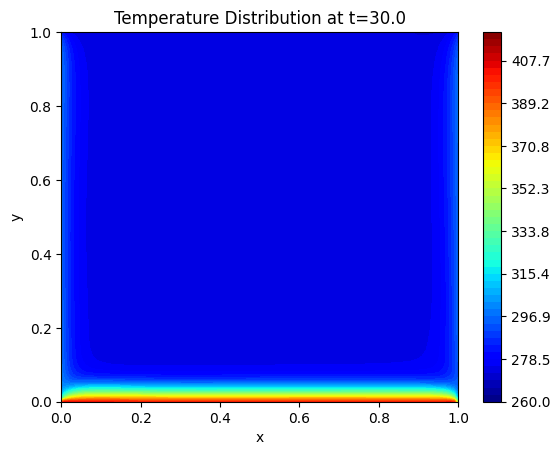

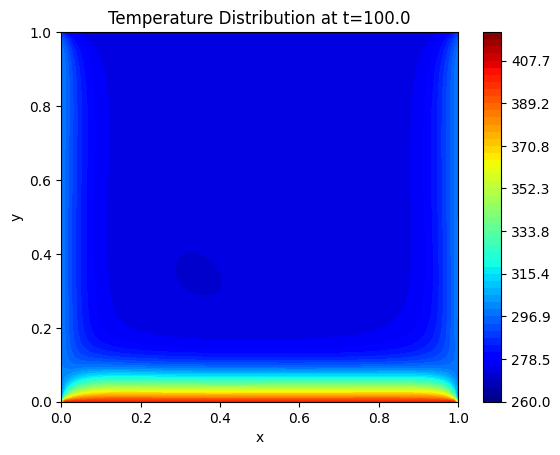

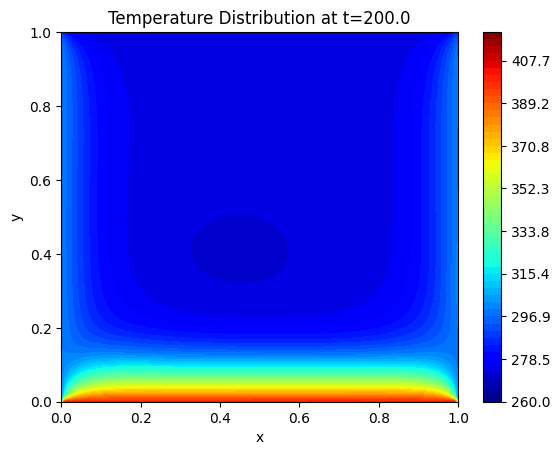

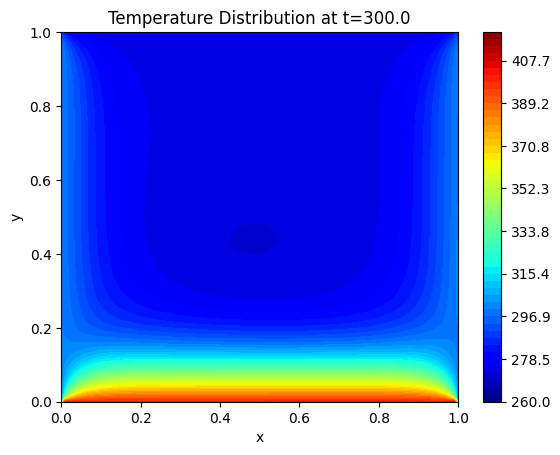

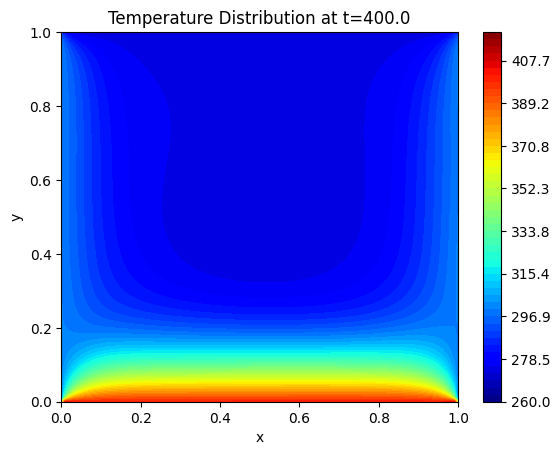

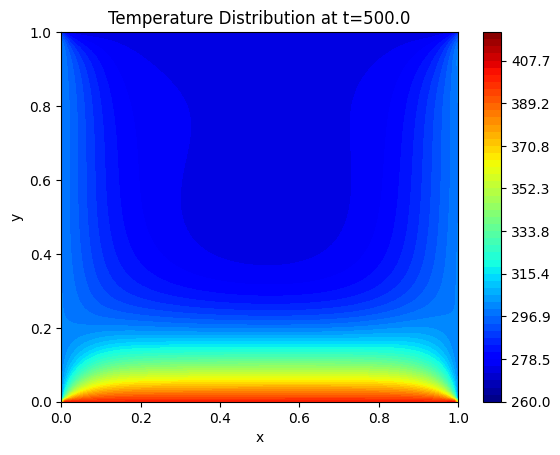

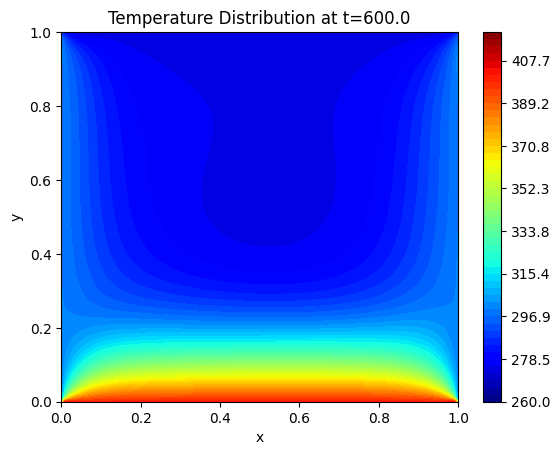

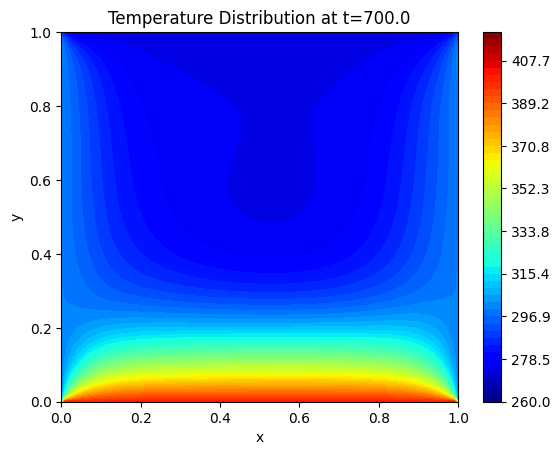

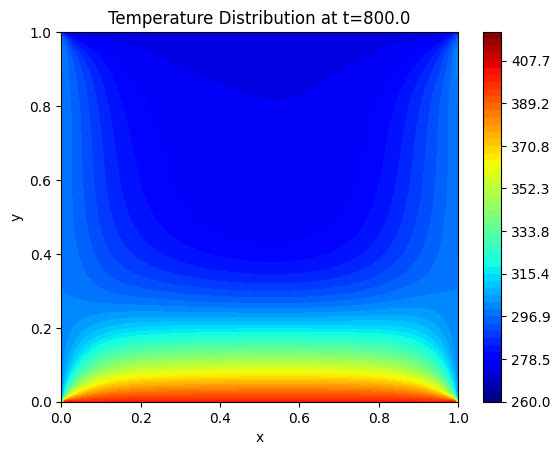

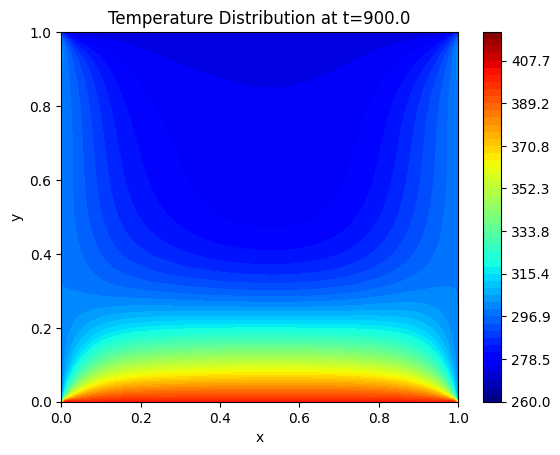

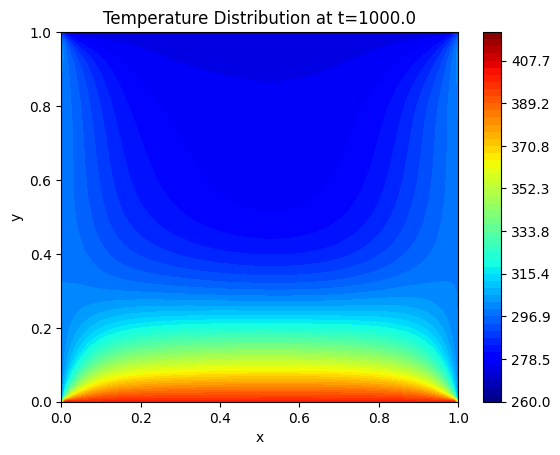

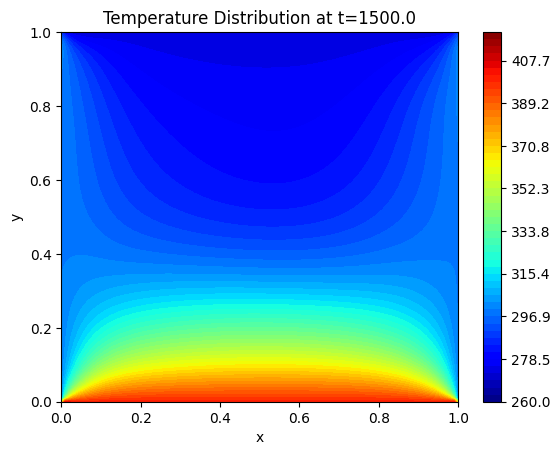

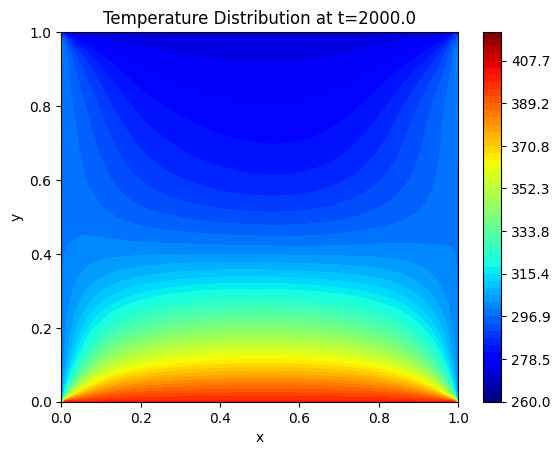

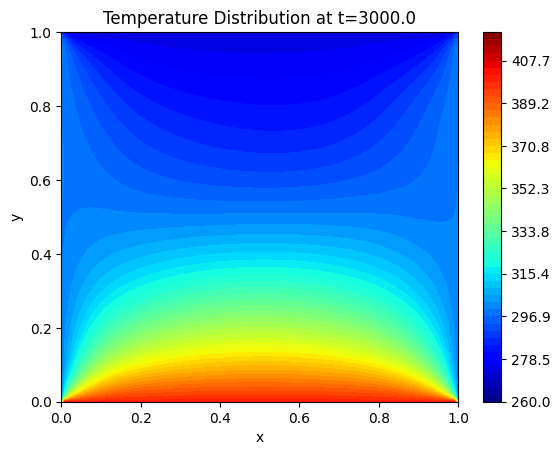

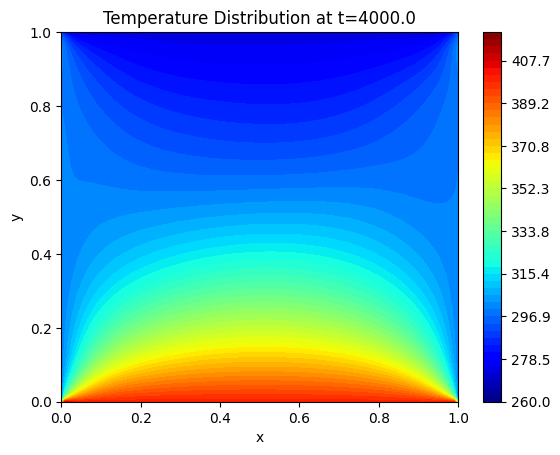

In [ ]:



time_points = np.array([0,10,20,30,100,200,300,400,500,600,700,800,900,1000,1500,2000,3000,4000]) /4000


def plot_temperature_distribution(model, time_points):
    model.net.eval()
    with torch.no_grad():
        for t in time_points:

            x = torch.linspace(x_min, x_max, 100)
            y = torch.linspace(y_min, y_max, 100)
            xx, yy = torch.meshgrid(x, y)
            tt = torch.full_like(xx, t)
            X_eval = torch.stack((xx.flatten(), yy.flatten(), tt.flatten()), dim=1).to(device)


            T_eval, _, _ = model.predict(X_eval)
            T_eval = T_eval.reshape(xx.shape)*400


            plt.figure()
            plt.title(f'Temperature Distribution at t={t*4000}')
            #plt.contourf(xx.cpu().numpy(), yy.cpu().numpy(), T_eval.cpu().numpy(), cmap='hot')
            levels = np.linspace(260, 420, 53)
            plt.contourf(xx.cpu().numpy(), yy.cpu().numpy(), T_eval.cpu().numpy(), levels=levels, cmap='jet')
            plt.colorbar()
            #plt.colorbar()
            plt.xlabel('x')
            plt.ylabel('y')
            plt.show()


plot_temperature_distribution(pinn, time_points)

In [20]:
from google.colab import files

def create_temperature_gif(model, time_points, filename="/content/temperature_distribution.gif"):
    model.net.eval()  # Set model to evaluation mode
    with torch.no_grad():
        frames = []  # List to store frames for the GIF
        for t in time_points:
            # Generate grid
            x = torch.linspace(x_min, x_max, 100)
            y = torch.linspace(y_min, y_max, 100)
            xx, yy = torch.meshgrid(x, y)
            tt = torch.full_like(xx, t)
            X_eval = torch.stack((xx.flatten(), yy.flatten(), tt.flatten()), dim=1).to(device)

            # Predict temperature
            T_eval, _, _ = model.predict(X_eval)
            T_eval = T_eval.reshape(xx.shape) * 400

            # Create plot
            fig, ax = plt.subplots()
            levels = np.linspace(260, 420, 53)
            contour = ax.contourf(xx.cpu().numpy(), yy.cpu().numpy(), T_eval.cpu().numpy(), levels=levels, cmap='jet')
            fig.colorbar(contour)
            ax.set_title(f'Temperature Distribution at t={t * 4000:.2f}')
            ax.set_xlabel('x')
            ax.set_ylabel('y')

            # Save frame
            frame_path = "/content/frame.png"
            plt.savefig(frame_path)
            plt.close(fig)

            # Verify if the frame file was saved
            if os.path.exists(frame_path):
                frames.append(imageio.imread(frame_path))
            else:
                print(f"Failed to save frame at {frame_path}")

        # Create GIF
        if frames:
            imageio.mimsave(filename, frames, fps=2)
            print(f"GIF saved as {filename}")
            # Download the GIF file
            files.download(filename)
        else:
            print("No frames were created, GIF not saved.")

# Example usage
if __name__ == "__main__":
    time_points = np.linspace(t_min, t_max, 30)  # Adjust as needed
    create_temperature_gif(pinn, time_points)


<ipython-input-20-569ba63f7cf7>:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(frame_path))


GIF saved as /content/temperature_distribution.gif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>